In [5]:
import numpy as np
import ENDFtk
import NDSampler
from NDSampler.angular.Uncertainty_Angular import Uncertainty_Angular
import matplotlib.pyplot as plt
from scipy import stats

In [6]:
tape = ENDFtk.tree.Tape.from_file('/home/pierre/Projects/LIB/JEFF33/26-Fe-56g.jeff33')
mf4mt2 = tape.MAT(tape.material_numbers[0]).MF(4).MT(2).parse()
angulard = tape.materials.front().section(4, 2).parse()
angularu = tape.materials.front().section(34, 2).parse()
uncertainty = Uncertainty_Angular(mf4mt2, angularu, mt_number=2)
reduced_size = len(uncertainty.covariance_index_map)

Creating angular distribution uncertainty for MT2...
Time for extracting coefficients: 0.0090 seconds
Time for extracting covariance matrix: 0.0040 seconds
Full relative covariance matrix shape: (252, 252)
Original matrix size: 252 x 252
Reduced matrix size: 168 x 168
Removed 84 null variance elements
✓ Stored covariance_index_map with 168 entries
Min eigenvalue: -5.935942507507391e-05
Applying trace-preserving positive-definite correction...
  Original matrix:
    Trace: 441.909297
    Min eigenvalue: -5.935943e-05
    Negative eigenvalues: 7
  Corrected matrix:
    Min eigenvalue: 9.999995e-09
    Trace: 441.909297
    Trace preservation: 1.00000000
    Scale factor applied: 0.99999951
  Reduced covariance[:4,:4]:
  [[0.09071996 0.01231999 0.01231999 0.01231999]
 [0.01231999 0.18039991 0.01231999 0.01231999]
 [0.01231999 0.01231999 0.04259998 0.01231999]
 [0.01231999 0.01231999 0.01231999 0.04580998]]
  Reconstructed from L[:4,:4]:
  [[0.09071996 0.01231999 0.01231999 0.01231999]
 [0

### Check eigenvalues of reduced matrix

**Better approach**: Eigenvalue thresholding with rescaling to preserve trace:
1. Decompose: $\Sigma = V \Lambda V^T$
2. Threshold: $\tilde{\Lambda} = \max(\Lambda, \epsilon)$ where $\epsilon$ is small positive value
3. **Rescale** to preserve trace: $\tilde{\Lambda}' = \tilde{\Lambda} \cdot \frac{\text{tr}(\Lambda)}{\text{tr}(\tilde{\Lambda})}$
4. Reconstruct: $\tilde{\Sigma} = V \tilde{\Lambda}' V^T$

In [7]:
reduced_cov = uncertainty.relative_covariance_matrix_full
eigenvals = np.linalg.eigvals(reduced_cov)
min_eigenval = np.min(eigenvals)
max_eigenval = np.max(eigenvals)

print(f"✓ Reduced covariance matrix eigenvalues:")
print(f"    Min eigenvalue: {min_eigenval:.6e}")
print(f"    Max eigenvalue: {max_eigenval:.6e}")
print(f"    Condition number: {max_eigenval/max_eigenval:.2e}")

# Test Cholesky decomposition
try:
    L_test = np.linalg.cholesky(reduced_cov)
    print(f"✓ Matrix is positive definite (Cholesky successful)")
    
    # Verify reconstruction
    reconstructed = L_test @ L_test.T
    frobenius_error = np.linalg.norm(reconstructed - reduced_cov, 'fro')
    print(f"✓ Cholesky reconstruction error: {frobenius_error:.2e}")
    
except np.linalg.LinAlgError:
    print(f"✗ Matrix is NOT positive definite")

✓ Reduced covariance matrix eigenvalues:
    Min eigenvalue: 9.999995e-09
    Max eigenvalue: 3.533681e+02
    Condition number: 1.00e+00
✓ Matrix is positive definite (Cholesky successful)
✓ Cholesky reconstruction error: 2.45e-15


In [8]:
n_samples = 1000
np.random.seed(42)  # Set random seed for reproducibility
samples = uncertainty.sample_parameters(num_samples=n_samples, sampling_method="Simple", mode="replace")

Full perturbation shape: (6, 42)
Applied 1000 samples to Legendre coefficients


# $\chi^2$ and K-S tests of Mahalanobis distance of samples

Sample statistics:
  Mean norm: 4.120002e-01 (should be ≈0)
  Max |mean|: 3.098886e-01

Mahalanobis distance statistics:
  Mean D²:    167.8728  (expected: 168.0)
  Median D²:  166.9117
  Std D²:     18.0173  (expected: 18.3303)
  Bias:       -0.1272  (-0.08%)

Statistical Tests:
  t-test (mean = 168):  t=-0.2231, p=0.8235
  Result: ✓ PASS (α=0.05)
  K-S test:             D=0.0182, p=0.8881
  Result: ✓ PASS (α=0.05)

=== VALIDATION SUMMARY ===
✅ SUCCESS: NDSampler implementation is CORRECT!
   Bias: -0.08% (< 2%)
   Statistical tests: PASSED


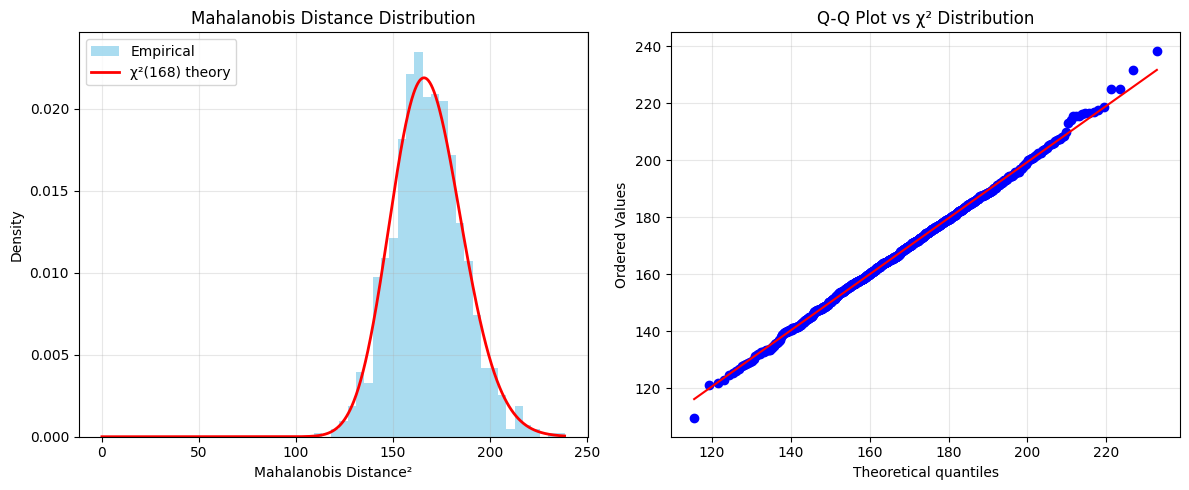


Distribution analysis:
  Sample min/max: [109.37, 238.46]
  Theoretical mean/std: 168.0 / 18.33
  Empirical mean/std: 167.87 / 18.02


In [9]:
Sigma_inv = np.linalg.inv(reduced_cov)

# Center samples (should be approximately zero mean)
mu_empirical = np.mean(samples, axis=0)
mu_0 = np.zeros_like(mu_empirical)  # Expected mean is zero

print(f"Sample statistics:")
print(f"  Mean norm: {np.linalg.norm(mu_empirical):.6e} (should be ≈0)")
print(f"  Max |mean|: {np.max(np.abs(mu_empirical)):.6e}")

# Compute Mahalanobis distances
D_squared = []
for x_i in samples:
    diff = x_i - mu_0
    D2 = diff @ Sigma_inv @ diff
    D_squared.append(D2)

D_squared = np.array(D_squared)
p = len(uncertainty.covariance_index_map)  # Number of parameters

# Statistical analysis
print(f"\nMahalanobis distance statistics:")
print(f"  Mean D²:    {np.mean(D_squared):.4f}  (expected: {p:.1f})")
print(f"  Median D²:  {np.median(D_squared):.4f}")
print(f"  Std D²:     {np.std(D_squared):.4f}  (expected: {np.sqrt(2*p):.4f})")
print(f"  Bias:       {np.mean(D_squared) - p:.4f}  ({(np.mean(D_squared)/p - 1)*100:+.2f}%)")

# Statistical tests
t_stat, t_p = stats.ttest_1samp(D_squared, p)
chi2_dist = stats.chi2(df=p)
ks_stat, ks_p = stats.kstest(D_squared, lambda x: chi2_dist.cdf(x))

print(f"\nStatistical Tests:")
print(f"  t-test (mean = {p}):  t={t_stat:.4f}, p={t_p:.4f}")
print(f"  Result: {'✓ PASS' if t_p > 0.05 else '✗ FAIL'} (α=0.05)")
print(f"  K-S test:             D={ks_stat:.4f}, p={ks_p:.4f}")
print(f"  Result: {'✓ PASS' if ks_p > 0.05 else '✗ FAIL'} (α=0.05)")

# Final validation
bias_percent = abs((np.mean(D_squared)/p - 1)*100)
print(f"\n=== VALIDATION SUMMARY ===")
if bias_percent < 2 and t_p > 0.05 and ks_p > 0.05:
    print(f"✅ SUCCESS: NDSampler implementation is CORRECT!")
    print(f"   Bias: {(np.mean(D_squared)/p - 1)*100:+.2f}% (< 2%)")
    print(f"   Statistical tests: PASSED")
else:
    print(f"❌ ISSUES DETECTED:")
    if bias_percent >= 2:
        print(f"   Large bias: {(np.mean(D_squared)/p - 1)*100:+.2f}%")
    if t_p <= 0.05:
        print(f"   t-test failed (p={t_p:.4f})")
    if ks_p <= 0.05:
        print(f"   K-S test failed (p={ks_p:.4f})")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax = axes[0]
ax.hist(D_squared, bins=30, density=True, alpha=0.7, color='skyblue', label='Empirical')

# Theoretical chi-squared
x_theory = np.linspace(0, np.max(D_squared), 1000)
y_theory = chi2_dist.pdf(x_theory)
ax.plot(x_theory, y_theory, 'r-', linewidth=2, label=f'χ²({p}) theory')

ax.set_xlabel('Mahalanobis Distance²')
ax.set_ylabel('Density')
ax.set_title('Mahalanobis Distance Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Q-Q plot
ax = axes[1]
stats.probplot(D_squared, dist=stats.chi2(df=p), plot=ax)
ax.set_title('Q-Q Plot vs χ² Distribution')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDistribution analysis:")
print(f"  Sample min/max: [{np.min(D_squared):.2f}, {np.max(D_squared):.2f}]")
print(f"  Theoretical mean/std: {p:.1f} / {np.sqrt(2*p):.2f}")
print(f"  Empirical mean/std: {np.mean(D_squared):.2f} / {np.std(D_squared):.2f}")

## Marginals tests

Analyzing 168 parameters from 1000 samples

=== NORMALITY TEST SUMMARY ===
Total parameters tested: 168
Shapiro-Wilk passed:     156/168 (92.9%)
K-S test passed:         168/168 (100.0%)
Anderson-Darling passed: 159/168 (94.6%)
All tests passed:        153/168 (91.1%)

⚠️  15 parameters failed at least one test
Failed parameter indices: [17, 42, 63, 72, 97, 99, 105, 119, 139, 142]...

=== NORMALITY TEST SUMMARY ===
Total parameters tested: 168
Shapiro-Wilk passed:     156/168 (92.9%)
K-S test passed:         168/168 (100.0%)
Anderson-Darling passed: 159/168 (94.6%)
All tests passed:        153/168 (91.1%)

⚠️  15 parameters failed at least one test
Failed parameter indices: [17, 42, 63, 72, 97, 99, 105, 119, 139, 142]...


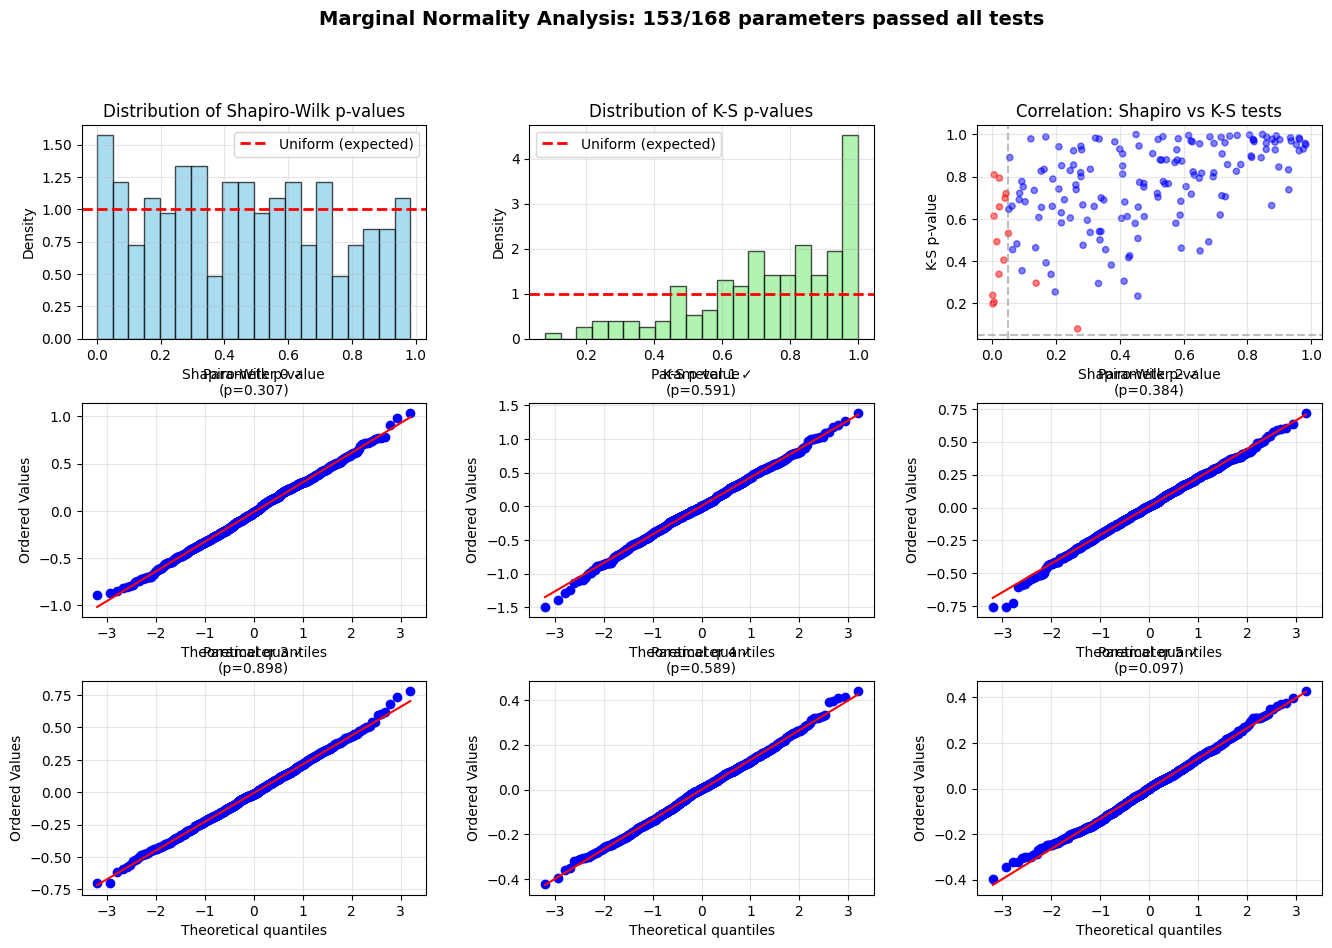


=== P-VALUE UNIFORMITY TESTS ===
(p-values should be uniformly distributed if marginals are truly normal)
Shapiro p-values: K-S stat=0.0755, p=0.2789
  Result: ✓ PASS (uniform distribution)
K-S p-values:     K-S stat=0.3878, p=0.0000
  Result: ✗ FAIL (uniform distribution)

=== FINAL ASSESSMENT ===
⚠️ BORDERLINE: 90–95% pass; inspect failed parameters.


In [13]:
# Comprehensive marginal normality tests for all 168 parameters
print(f"Analyzing {samples.shape[1]} parameters from {samples.shape[0]} samples")
print("=" * 80)

# Test each parameter for normality
normality_results = []
failed_params = []

for i in range(samples.shape[1]):
    param_samples = samples[:, i]
    
    # Shapiro-Wilk test (good for n < 5000)
    shapiro_stat, shapiro_p = stats.shapiro(param_samples)
    
    # Kolmogorov-Smirnov test
    param_mean = np.mean(param_samples)
    param_std = np.std(param_samples, ddof=1)
    ks_stat, ks_p = stats.kstest(param_samples, lambda x: stats.norm.cdf(x, loc=param_mean, scale=param_std))
    
    # Anderson-Darling test
    anderson_result = stats.anderson(param_samples, dist='norm')
    anderson_stat = anderson_result.statistic
    # Critical value at 5% significance
    anderson_critical = anderson_result.critical_values[2]  # Index 2 corresponds to 5%
    anderson_pass = anderson_stat < anderson_critical
    
    # Store results
    result = {
        'param_idx': i,
        'mean': param_mean,
        'std': param_std,
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'anderson_stat': anderson_stat,
        'anderson_critical': anderson_critical,
        'shapiro_pass': shapiro_p > 0.05,
        'ks_pass': ks_p > 0.05,
        'anderson_pass': anderson_pass
    }
    normality_results.append(result)
    
    # Track failures (all three tests must pass)
    if not (result['shapiro_pass'] and result['ks_pass'] and result['anderson_pass']):
        failed_params.append(i)

# Summary statistics
n_params = len(normality_results)
n_shapiro_pass = sum(r['shapiro_pass'] for r in normality_results)
n_ks_pass = sum(r['ks_pass'] for r in normality_results)
n_anderson_pass = sum(r['anderson_pass'] for r in normality_results)
n_all_pass = sum(r['shapiro_pass'] and r['ks_pass'] and r['anderson_pass'] for r in normality_results)

print(f"\n=== NORMALITY TEST SUMMARY ===")
print(f"Total parameters tested: {n_params}")
print(f"Shapiro-Wilk passed:     {n_shapiro_pass}/{n_params} ({100*n_shapiro_pass/n_params:.1f}%)")
print(f"K-S test passed:         {n_ks_pass}/{n_params} ({100*n_ks_pass/n_params:.1f}%)")
print(f"Anderson-Darling passed: {n_anderson_pass}/{n_params} ({100*n_anderson_pass/n_params:.1f}%)")
print(f"All tests passed:        {n_all_pass}/{n_params} ({100*n_all_pass/n_params:.1f}%)")

if len(failed_params) > 0:
    print(f"\n⚠️  {len(failed_params)} parameters failed at least one test")
    print(f"Failed parameter indices: {failed_params[:10]}{'...' if len(failed_params) > 10 else ''}")
else:
    print(f"\n✅ All {n_params} parameters passed all normality tests!")

# Distribution of p-values (should be uniform under null hypothesis)
shapiro_pvals = [r['shapiro_p'] for r in normality_results]
ks_pvals = [r['ks_p'] for r in normality_results]

# Visualizations
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Histogram of Shapiro-Wilk p-values
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(shapiro_pvals, bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Uniform (expected)')
ax1.set_xlabel('Shapiro-Wilk p-value')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Shapiro-Wilk p-values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Histogram of K-S p-values
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(ks_pvals, bins=20, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Uniform (expected)')
ax2.set_xlabel('K-S p-value')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of K-S p-values')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Scatter: Shapiro vs K-S p-values
ax3 = fig.add_subplot(gs[0, 2])
colors = ['red' if i in failed_params else 'blue' for i in range(n_params)]
ax3.scatter(shapiro_pvals, ks_pvals, c=colors, alpha=0.5, s=20)
ax3.axhline(0.05, color='gray', linestyle='--', alpha=0.5)
ax3.axvline(0.05, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('Shapiro-Wilk p-value')
ax3.set_ylabel('K-S p-value')
ax3.set_title('Correlation: Shapiro vs K-S tests')
ax3.grid(True, alpha=0.3)

# 4. Sample Q-Q plots for first 6 parameters
for idx, param_idx in enumerate(range(6)):
    ax = fig.add_subplot(gs[1 + idx//3, idx%3])
    param_samples = samples[:, param_idx]
    stats.probplot(param_samples, dist="norm", plot=ax)
    
    result = normality_results[param_idx]
    status = '✓' if result['shapiro_pass'] and result['ks_pass'] and result['anderson_pass'] else '✗'
    ax.set_title(f'Parameter {param_idx} {status}\n(p={result["shapiro_p"]:.3f})', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Marginal Normality Analysis: {n_all_pass}/{n_params} parameters passed all tests', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

# Statistical test for p-value uniformity (should be uniform if samples are truly normal)
# Kolmogorov-Smirnov test for uniformity
uniform_ks_shapiro, uniform_p_shapiro = stats.kstest(shapiro_pvals, 'uniform')
uniform_ks_ks, uniform_p_ks = stats.kstest(ks_pvals, 'uniform')

print(f"\n=== P-VALUE UNIFORMITY TESTS ===")
print(f"(p-values should be uniformly distributed if marginals are truly normal)")
print(f"Shapiro p-values: K-S stat={uniform_ks_shapiro:.4f}, p={uniform_p_shapiro:.4f}")
print(f"  Result: {'✓ PASS' if uniform_p_shapiro > 0.05 else '✗ FAIL'} (uniform distribution)")
print(f"K-S p-values:     K-S stat={uniform_ks_ks:.4f}, p={uniform_p_ks:.4f}")
print(f"  Result: {'✓ PASS' if uniform_p_ks > 0.05 else '✗ FAIL'} (uniform distribution)")

# Overall assessment
print(f"\n=== FINAL ASSESSMENT ===")
frac_primary = n_shapiro_pass / n_params

if frac_primary >= 0.99:
    print("✅ EXCELLENT: ≳99% of marginals pass Shapiro–Wilk.")
elif frac_primary >= 0.95:
    print("✅ GOOD: ≥95% of marginals pass Shapiro–Wilk.")
elif frac_primary >= 0.90:
    print("⚠️ BORDERLINE: 90–95% pass; inspect failed parameters.")
else:
    print("❌ ISSUES: <90% pass; check sampling/model.")


There are more than 90\% tests that passed.

We have to keep in mind that even if all parameters are perfectly normal, we expect 5\% of rejections (5% of 168 is about 8 fails).

Our sample size is large (> 300), Shapiro-Wilk in sensitive to tiny deviations. Therefore best to look at QQ-plots;

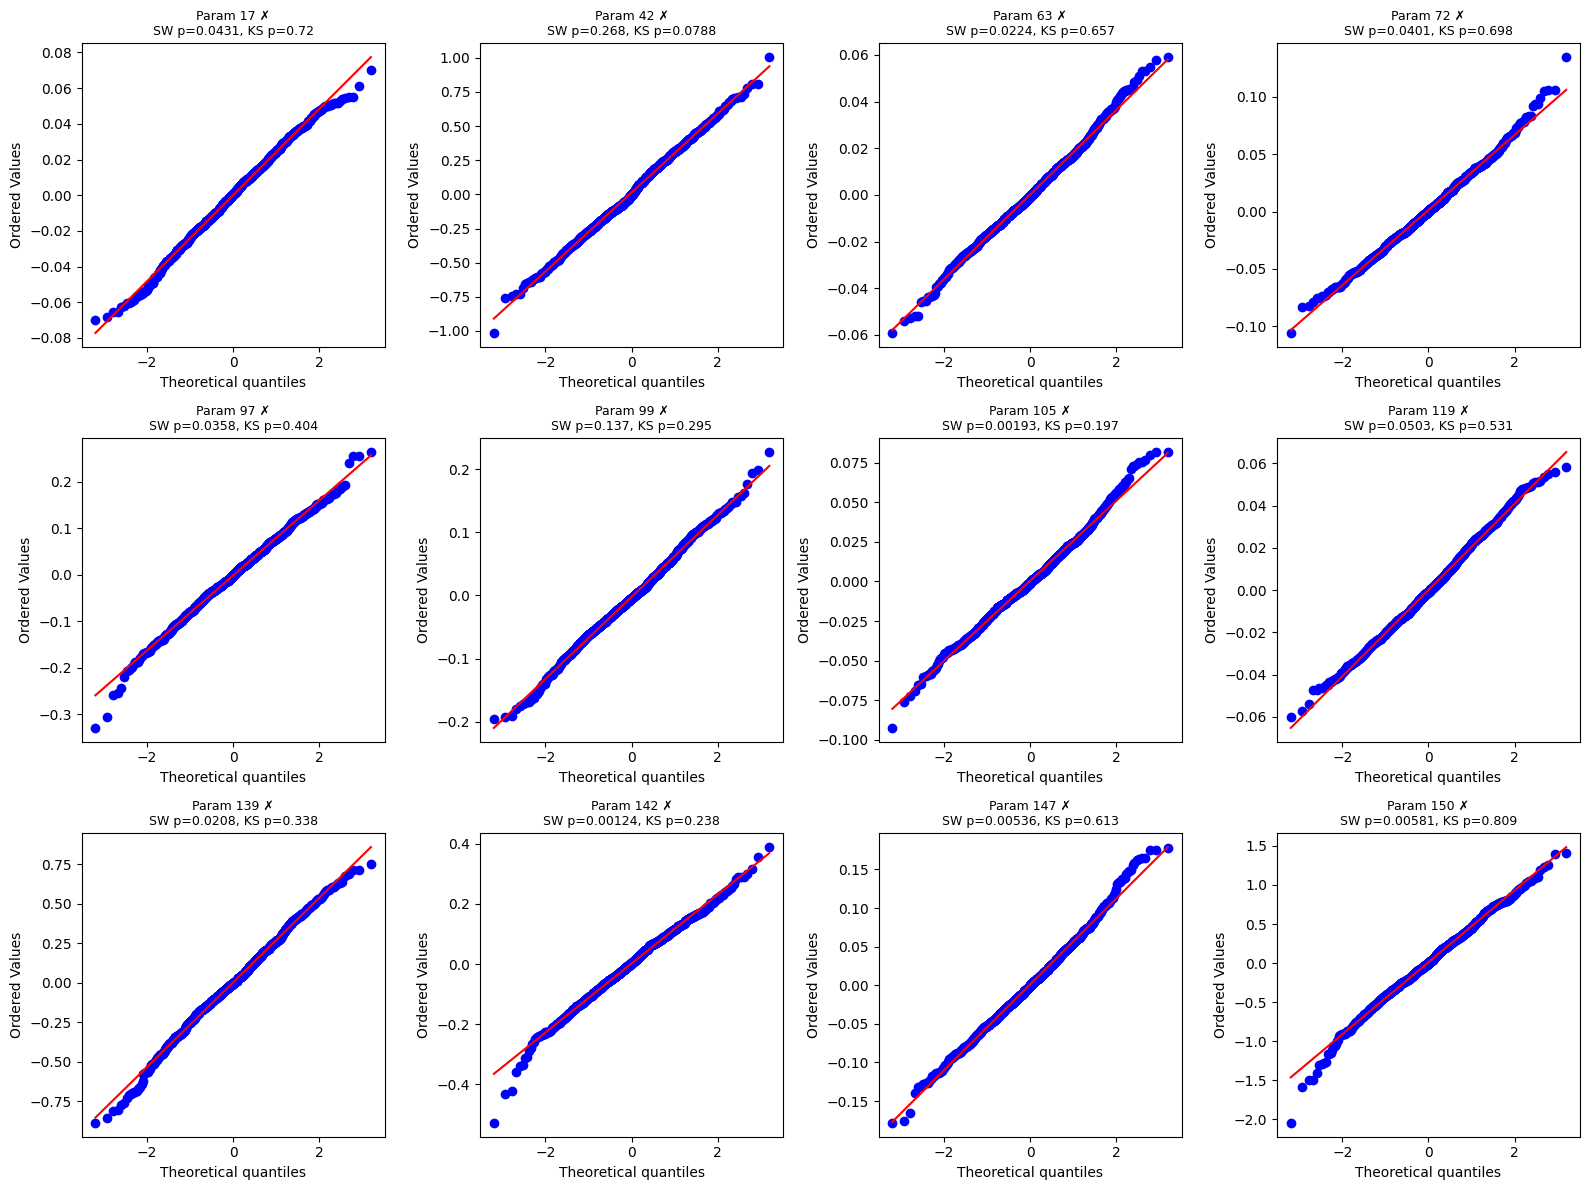

In [11]:
import math

# Take first N failed params for detailed inspection
N = min(12, len(failed_params))
n_cols = 4
n_rows = math.ceil(N / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.ravel()

for j in range(N):
    idx = failed_params[j]
    ax = axes[j]
    param_samples = samples[:, idx]
    stats.probplot(param_samples, dist="norm", plot=ax)
    
    r = normality_results[idx]
    status = '✗'
    ax.set_title(
        f'Param {idx} {status}\n'
        f'SW p={r["shapiro_p"]:.3g}, KS p={r["ks_p"]:.3g}',
        fontsize=9
    )

# Hide unused axes if any
for k in range(N, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


Let us check QQ-correlation and plot histogram + KDE + fitted normal pdf overlays for them. 

0.995–0.999 => small mild deviation (almost imperceptible)

In [16]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def qq_corr(sample):
    x = np.sort(sample)
    n = len(x)
    p = (np.arange(1, n+1) - 0.5) / n
    th = stats.norm.ppf(p)
    return np.corrcoef(th, x)[0, 1]

# Compute QQ correlation for each parameter
qq_corrs = np.array([qq_corr(samples[:, i]) for i in range(samples.shape[1])])

# Indices of "worst" parameters = lowest QQ correlation
N_WORST = 6  # change to 10, 12, ... if you want more
worst_idx = np.argsort(qq_corrs)[:N_WORST]

print("Worst parameters by QQ-correlation:")
for i in worst_idx:
    print(f"Param {i}: qq_corr = {qq_corrs[i]:.6f}")


Worst parameters by QQ-correlation:
Param 142: qq_corr = 0.997111
Param 105: qq_corr = 0.997453
Param 150: qq_corr = 0.997694
Param 157: qq_corr = 0.997744
Param 147: qq_corr = 0.997847
Param 153: qq_corr = 0.998195


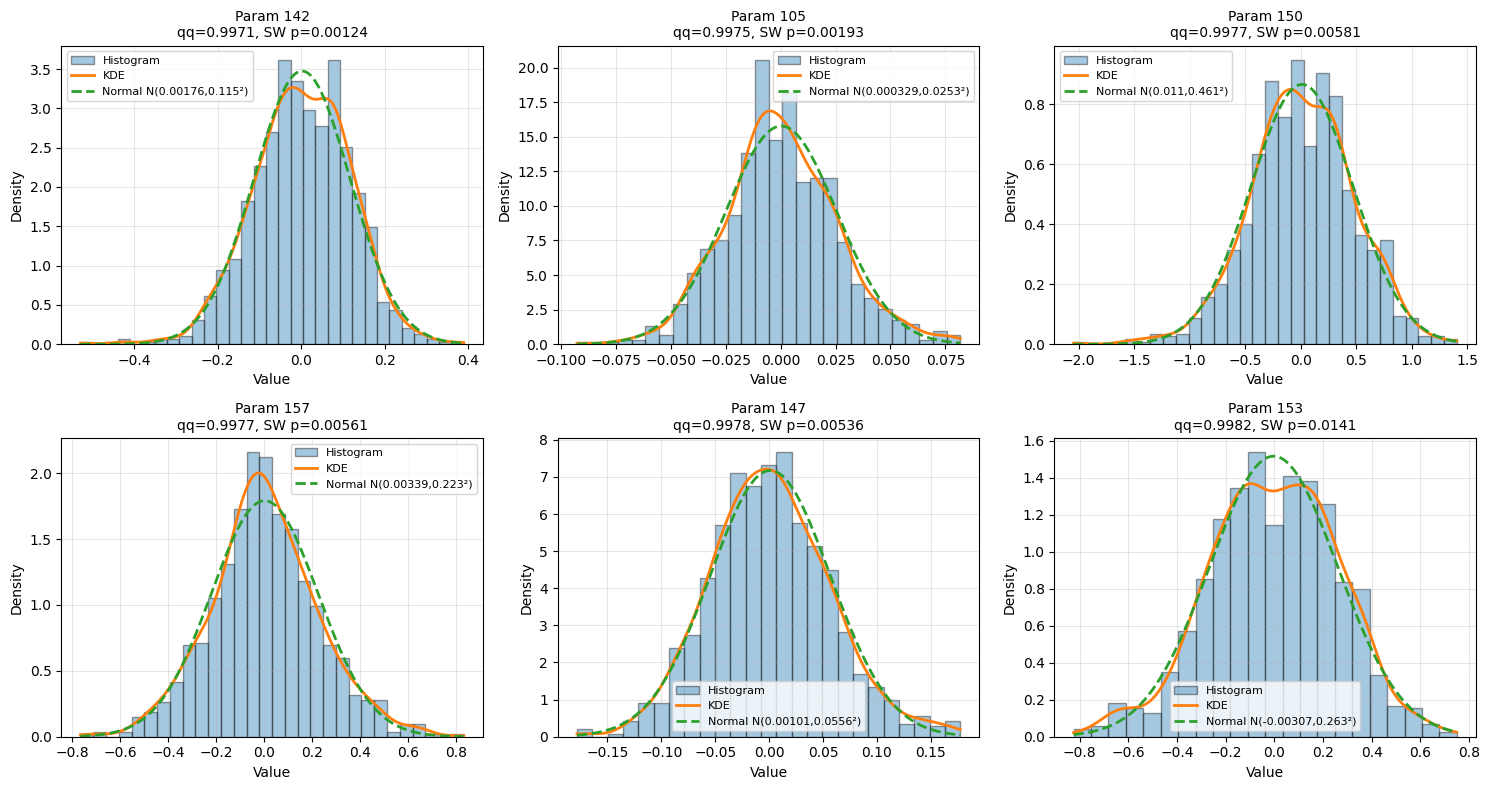

In [17]:
from scipy.stats import gaussian_kde, norm

n_cols = 3
n_rows = int(np.ceil(N_WORST / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = np.atleast_1d(axes).ravel()

for ax, idx in zip(axes, worst_idx):
    data = samples[:, idx]
    mu = np.mean(data)
    sigma = np.std(data, ddof=1)

    # Histogram (empirical density)
    ax.hist(data, bins='auto', density=True, alpha=0.4, edgecolor='black', label='Histogram')

    # KDE (smooth empirical density)
    kde = gaussian_kde(data)
    x_min, x_max = np.min(data), np.max(data)
    x_grid = np.linspace(x_min, x_max, 400)
    ax.plot(x_grid, kde(x_grid), linewidth=2, label='KDE')

    # Fitted normal density
    ax.plot(x_grid, norm.pdf(x_grid, loc=mu, scale=sigma),
            linestyle='--', linewidth=2, label=f'Normal N({mu:.3g},{sigma:.3g}²)')

    # Title with stats
    # If you still have normality_results:
    r = normality_results[idx]
    ax.set_title(
        f"Param {idx}\n"
        f"qq={qq_corrs[idx]:.4f}, SW p={r['shapiro_p']:.3g}",
        fontsize=10
    )
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

# Hide any unused subplots
for k in range(len(worst_idx), len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()
